### Import Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import keras
from keras.optimizers import Adam
import time
from sklearn import linear_model, preprocessing
from sklearn.metrics import r2_score
from scipy import stats
from IPython.core.display import HTML
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Read and Format data

In [2]:
data = pd.read_csv("data.csv", index_col=0)
norm_data = (data-data.mean())/data.std()
X = norm_data.drop("Happiness Score", axis=1)
Y = norm_data[["Happiness Score"]]

In [3]:
data.head(5)

,Happiness Score,Household Size,Income Per Capita,Percent Urban,Births Per 1000,Deaths Per 1000,Life Expectancy at Birth,Percent Young (<15),Percent Old (>65),Infant Mortality Rate,Fertility Rate
Switzerland,7.587,2.3,70140.0,0.85,10.0,8.0,84.0,0.15,0.18,3.3,1.4
Iceland,7.561,2.6,55920.0,0.94,12.0,6.0,83.0,0.19,0.14,1.7,1.7
Denmark,7.527,2.1,57980.0,0.88,11.0,9.0,81.0,0.16,0.20,3.1,1.7
Norway,7.522,2.2,70530.0,0.82,10.0,8.0,83.0,0.17,0.18,2.1,1.5
Canada,7.427,2.5,49430.0,0.81,10.0,8.0,82.0,0.16,0.18,4.7,1.5


### Define Neural Network

In [131]:
# 1D CNN
def build_model(input_shape):
    # Define model
    model = keras.models.Sequential([
            keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=input_shape),
            keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu'),
            keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu'),
            keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu'),
            keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu'),
            keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu'),
            keras.layers.Flatten(),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(1)
    ])

    # Compile Model
    model.compile(loss='mse', optimizer=Adam(lr=0.002))
    
    return model

### Leave-one-out cross validation

In [132]:
cv_results = pd.DataFrame(index=["MLR Prediction", "Lasso Prediction", "Ridge Prediction", "CNN Prediction", "Observed"])

fold = X.shape[0]
tik = time.time()

for i in range(fold):
    # Reset keras session to reduce model clutter
    keras.backend.clear_session()
    
    # Select test sample
    sample = X.iloc[i].name
    
    # Seperate test sample from train samples
    trainX = X.drop(sample)
    testX = X.iloc[[i]]
    trainY = Y.drop(sample)
    testY = Y.iloc[[i]]
    
    # Train MLR
    regr = linear_model.LinearRegression()
    regr.fit(trainX, trainY)
    
    # Train Lasso
    lasso = linear_model.Lasso(alpha=0.01)
    lasso.fit(trainX, trainY)
    
    # Train Ridge
    ridge = linear_model.Ridge(alpha=20)
    ridge.fit(trainX, trainY)
    
    # Record predictions of linear models
    mlr_pred = regr.predict(testX)[0][0]
    lasso_pred = lasso.predict(testX)[0]
    ridge_pred = ridge.predict(testX)[0][0]
    
    # Reshape data for 1D CNN
    trainX = np.asarray(trainX).reshape((trainX.shape[0],trainX.shape[1],1))
    testX = np.asarray(testX).reshape((testX.shape[0],testX.shape[1],1))
    trainY = np.asarray(trainY)
    testY = np.asarray(testY)
    
    # Reset CNN
    model = build_model((trainX.shape[1],1))

    # Train the CNN
    model.fit(trainX, trainY, batch_size=32, epochs=100, verbose=0)

    # Record CNN predictions
    cnn_pred = model.predict(testX)[0][0]
    
    # Record observed values
    observed = testY[0][0]
    
    # Display training information
    print("\n==========[ ", i+1, "/", fold," ]==========", sep="")
    print("Sample:", sample, "\nMLR Predicition:", mlr_pred, "\nLasso Predicition:", ridge_pred, "\nRidge Predicition:", lasso_pred, "\nCNN Predicition:", cnn_pred, "\nObserved:", observed)
    
    # Cache training information
    cv_results[sample] = (mlr_pred, lasso_pred, ridge_pred, cnn_pred, observed)

cv_results = cv_results.T

# Display elapsed time
tok = time.time()
print("\nTotal elapsed time:", tok-tik, "seconds\n")


==========[ 1/134 ]==========
Sample: Switzerland 
MLR Predicition: 1.6099746812697235 
Lasso Predicition: 1.3545464615732923 
Ridge Predicition: 1.4658104789634998 
CNN Predicition: 1.4368308 
Observed: 1.8854015844551386

==========[ 2/134 ]==========
Sample: Iceland 
MLR Predicition: 1.4636359535616394 
Lasso Predicition: 1.2511804569675842 
Ridge Predicition: 1.3328610802574374 
CNN Predicition: 1.5099217 
Observed: 1.8629643775859106

==========[ 3/134 ]==========
Sample: Denmark 
MLR Predicition: 1.073901138727441 
Lasso Predicition: 1.1057941798922768 
Ridge Predicition: 1.1677340765220974 
CNN Predicition: 1.4614477 
Observed: 1.833623414756922

==========[ 4/134 ]==========
Sample: Norway 
MLR Predicition: 1.5851783723116144 
Lasso Predicition: 1.313644059167556 
Ridge Predicition: 1.414143931110442 
CNN Predicition: 1.7037413 
Observed: 1.8293085672820706

==========[ 5/134 ]==========
Sample: Canada 
MLR Predicition: 1.0319211598391358 
Lasso Predicition: 0.9776744677938035

### Results

In [133]:
cv_results = cv_results*data.std()["Happiness Score"]+data.mean()["Happiness Score"]
cv_results.T

,Switzerland,Iceland,Denmark,Norway,Canada,Finland,Netherlands,Sweden,New Zealand,Australia,...,Tanzania,Madagascar,Chad,Guinea,Burkina Faso,Afghanistan,Rwanda,Benin,Burundi,Togo
MLR Prediction,7.267838,7.098262,6.646642,7.239104,6.597996,6.454521,6.911332,6.926990,6.539082,7.014051,...,4.274775,4.405909,3.728603,4.034294,3.826610,3.761539,4.595511,4.077064,3.712147,4.071102
Lasso Prediction,7.100782,6.946722,6.755374,7.040912,6.592937,6.409502,6.840064,6.781272,6.496602,6.837144,...,4.386511,4.522065,3.570492,3.895983,3.931368,3.903283,4.570712,4.131199,4.045122,4.304799
Ridge Prediction,6.971851,6.852071,6.683599,6.924453,6.535135,6.372878,6.761069,6.706182,6.454587,6.742179,...,4.383760,4.493852,3.540571,3.884024,3.947504,3.949766,4.552554,4.102435,4.051961,4.311531
CNN Prediction,7.067201,7.151898,7.095727,7.376494,6.779304,6.731032,6.880370,7.414921,6.768035,6.812101,...,4.151989,4.414353,4.184211,4.240356,3.966022,4.232080,4.183845,4.196390,3.856798,4.415702
Observed,7.587000,7.561000,7.527000,7.522000,7.427000,7.406000,7.378000,7.364000,7.286000,7.284000,...,3.781000,3.681000,3.667000,3.656000,3.587000,3.575000,3.465000,3.340000,2.905000,2.839000


In [134]:
# Calculate and display R2 score and Mean Squared Error
observations = np.array(cv_results["Observed"])
# Record Predictions
mlr_pred = np.array(cv_results["MLR Prediction"])
cnn_pred = np.array(cv_results["CNN Prediction"])
lasso_pred = np.array(cv_results["Lasso Prediction"])
ridge_pred = np.array(cv_results["Ridge Prediction"])
# Calculate MSE
mlr_mse = np.square(observations - mlr_pred).mean()
cnn_mse = np.square(observations - cnn_pred).mean()
lasso_mse = np.square(observations - lasso_pred).mean()
ridge_mse = np.square(observations - ridge_pred).mean()
# Calculate R2
mlr_r2 = r2_score(observations, mlr_pred)
cnn_r2 = r2_score(observations, cnn_pred)
lasso_r2 = r2_score(observations, lasso_pred)
ridge_r2 = r2_score(observations, ridge_pred)
# Print!
print("MLR R2:", mlr_r2)
# print("MLR MSE:", mlr_mse)
print("Lasso R2:", lasso_r2)
# print("Lasso MSE:", lasso_mse)
print("Ridge R2:", ridge_r2)
# print("Ridge MSE:", ridge_mse)
print("CNN R2:", cnn_r2)
# print("CNN MSE:", cnn_mse)

MLR R2: 0.6343162414139591
Lasso R2: 0.641815959721023
Ridge R2: 0.650202849183275
CNN R2: 0.700444108082741


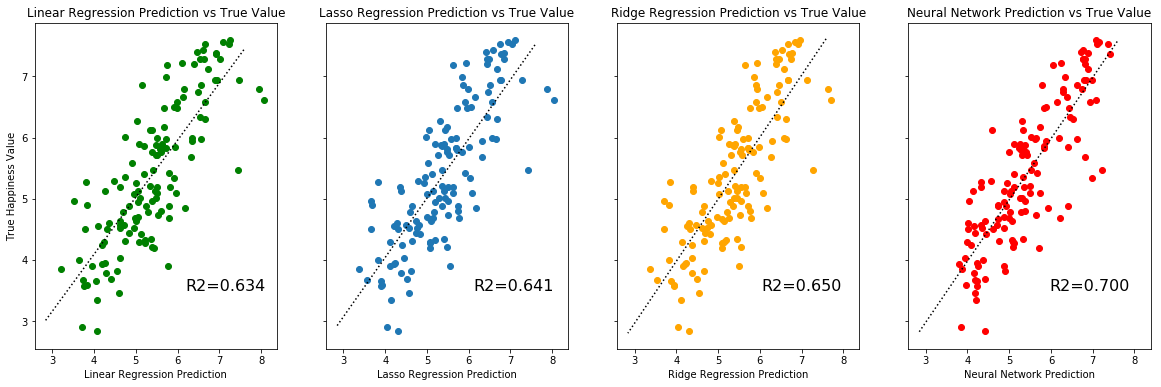

In [147]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4, sharey=True, sharex=True)
fig.set_figwidth(20)
fig.set_figheight(6)
ax1.scatter(mlr_pred, observations, c="g")
m, b, r_value, p_value, std_err = stats.linregress(mlr_pred, observations)
ax1.plot(observations, np.multiply(observations, m)+b,"k:")
ax1.set_xlabel("Linear Regression Prediction")
ax1.set_ylabel("True Happiness Value")
ax1.set_title("Linear Regression Prediction vs True Value")
ax2.scatter(lasso_pred, observations)
m, b, r_value, p_value, std_err = stats.linregress(lasso_pred, observations)
ax2.plot(observations, np.multiply(observations, m)+b,"k:")
ax2.set_xlabel("Lasso Regression Prediction")
ax2.set_title("Lasso Regression Prediction vs True Value")
ax4.scatter(cnn_pred, observations, c="r")
m, b, r_value, p_value, std_err = stats.linregress(cnn_pred, observations)
ax4.plot(observations, np.multiply(observations, m)+b,"k:")
ax4.set_xlabel("Neural Network Prediction")
ax4.set_title("Neural Network Prediction vs True Value")
ax3.scatter(ridge_pred, observations, c="orange")
m, b, r_value, p_value, std_err = stats.linregress(ridge_pred, observations)
ax3.plot(observations, np.multiply(observations, m)+b,"k:")
ax3.set_xlabel("Ridge Regression Prediction")
ax3.set_title("Ridge Regression Prediction vs True Value")
fig.text(0.23,0.26,"R2=0.634", fontsize=16)
fig.text(0.43,0.26,"R2=0.641", fontsize=16)
fig.text(0.63,0.26,"R2=0.650", fontsize=16);
fig.text(0.83,0.26,"R2=0.700", fontsize=16);

### Additional Info

In [148]:
display(HTML(cv_results.to_html()))

,MLR Prediction,Lasso Prediction,Ridge Prediction,CNN Prediction,Observed
Switzerland,7.267838,7.100782,6.971851,7.067201,7.587
Iceland,7.098262,6.946722,6.852071,7.151898,7.561
Denmark,6.646642,6.755374,6.683599,7.095727,7.527
Norway,7.239104,7.040912,6.924453,7.376494,7.522
Canada,6.597996,6.592937,6.535135,6.779304,7.427
Finland,6.454521,6.409502,6.372878,6.731032,7.406
Netherlands,6.911332,6.840064,6.761069,6.880370,7.378
Sweden,6.926990,6.781272,6.706182,7.414921,7.364
New Zealand,6.539082,6.496602,6.454587,6.768035,7.286
Australia,7.014051,6.837144,6.742179,6.812101,7.284


In [ ]:
# Train MLR
regr = linear_model.LinearRegression()
regr.fit(X, Y)

# Train Lasso
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X, Y)

# Train Ridge
ridge = linear_model.Ridge(alpha=20)
ridge.fit(X, Y);

In [150]:
pd.DataFrame(regr.coef_, columns=X.columns).T.rename(columns={0:"MLR Coefficient"})

,MLR Coefficient
Household Size,-0.242507
Income Per Capita,0.377464
Percent Urban,0.201075
Births Per 1000,-0.264378
Deaths Per 1000,0.084637
Life Expectancy at Birth,0.684992
Percent Young (<15),0.553909
Percent Old (>65),-0.279649
Infant Mortality Rate,0.303098
Fertility Rate,-0.270955


In [151]:
pd.DataFrame(lasso.coef_, index=X.columns).rename(columns={0:"Lasso Coefficients"})

,Lasso Coefficients
Household Size,-0.156563
Income Per Capita,0.324198
Percent Urban,0.204185
Births Per 1000,-0.000000
Deaths Per 1000,-0.138457
Life Expectancy at Birth,0.226485
Percent Young (<15),0.000000
Percent Old (>65),-0.000000
Infant Mortality Rate,0.080043
Fertility Rate,-0.104794


In [152]:
pd.DataFrame(ridge.coef_, columns=X.columns).T.rename(columns={0:"Ridge Coefficients"})

,Ridge Coefficients
Household Size,-0.137895
Income Per Capita,0.280244
Percent Urban,0.202579
Births Per 1000,-0.057701
Deaths Per 1000,-0.142904
Life Expectancy at Birth,0.171815
Percent Young (<15),0.007142
Percent Old (>65),0.023943
Infant Mortality Rate,0.034098
Fertility Rate,-0.082524
